1. Compute the value analytically (1 point)

2. Compute the integral using trapezoidal rule (1 point)

3. Parallelize using MPI. You should be able to choose any number of MPI processes regardless of the number of discretization points. (2 points)

4. Plot the speedup vs number of processors (1 point)

5. Plot integration error vs the discretization size (1 point)

 $\int_{0}^{1} x^3 + 4x \,dx = (\frac{1}{4}x^4 + \frac{4x^2}{2})|_0^1 = 2.25$

In [6]:
! pip install mpi4py

In [7]:
import numpy as np

def trapezoidal_rule(func, a, b, points_number=10000):
    xs = np.linspace(a, b, points_number)
    dx = xs[1] - xs[0]
    return (func(xs[1:-1]).sum() + (func(xs[0]) + func(xs[-1])) / 2) * dx

def func(x):
    return  x ** 3 + 4 * x

print(f'By trapezoidal rule values is {trapezoidal_rule(func, 0, 1, 1000)}')

By trapezoidal rule values is 2.250000250500751


In [8]:
%%writefile integral.py

from mpi4py import MPI
import numpy as np

def trapezoidal_rule(func, a, b, points_number=10000):
    xs = np.linspace(a, b, points_number)
    dx = xs[1] - xs[0]
    return (func(xs[1:-1]).sum() + (func(xs[0]) + func(xs[-1])) / 2) * dx

def func(x):
    return  x ** 3 + 4 * x

def main():
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
    
    a = 0
    b = 1
    points_number = 10000

    points_per_rank = list(map(len, np.array_split(np.ones(points_number), size)))[rank]
    
    a_rank = a + (b - a) / size * rank
    b_rank = a_rank + (b - a) / size
    start = MPI.Wtime()
    partial_integral = np.zeros(1)
    partial_integral[0] = trapezoidal_rule(func, a_rank, b_rank, points_per_rank)
    
    integral = None
    end = MPI.Wtime()
    if rank == 0:
        integral = np.zeros(1)
    comm.Reduce(partial_integral, integral, op=MPI.SUM, root=0)

    if rank == 0:
        print(f'Size is {size} time is {end - start}')
        print(f'Integral is {integral}')

main()

Overwriting integral.py


In [9]:
!mpirun  --allow-run-as-root  -n $n python3 integral.py 

Size is 9 time is 0.00023752999999260282
Integral is [2.25]


In [10]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

processes = np.arange(1, 10, 1)
    
for n in tqdm(processes):
    !mpirun  --allow-run-as-root  -n $n python3 integral.py 


  0%|          | 0/9 [00:00<?, ?it/s]

Size is 1 time is 0.0009366730000124335
Integral is [2.25]
Size is 2 time is 0.0005594739999992271
Integral is [2.25]
Size is 3 time is 0.0004443809999941095
Integral is [2.25]
Size is 4 time is 0.0003478389999997944
Integral is [2.25]
Size is 5 time is 0.007413080999981503
Integral is [2.25]
Size is 6 time is 0.0002902310000081343
Integral is [2.25]
Size is 7 time is 0.0010813700000085191
Integral is [2.25]
Size is 8 time is 0.00023322000001257948
Integral is [2.25]
Size is 9 time is 0.00023913100000072518
Integral is [2.25]


In [11]:
times = [0.0009366730000124335 ,
0.0005594739999992271 ,
0.0004443809999941095 ,
0.0003478389999997944 ,
0.007413080999981503  ,
0.0002902310000081343 ,
0.0010813700000085191 ,
0.00023322000001257948,
0.00023913100000072518]

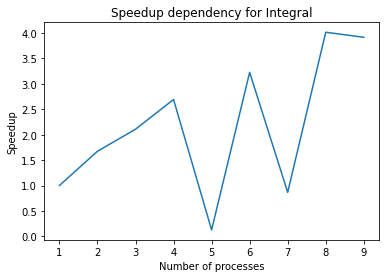

In [12]:
plt.plot(processes, [times[0] / time for time in times])
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.title('Speedup dependency for Integral')
plt.show()

In [17]:
discrete_grid = np.logspace(1, 8, 40).astype('int')

errors = []
for points_number in tqdm(discrete_grid):
    errors.append(abs(2.25 - trapezoidal_rule(func, 0, 1, points_number)))

  0%|          | 0/40 [00:00<?, ?it/s]

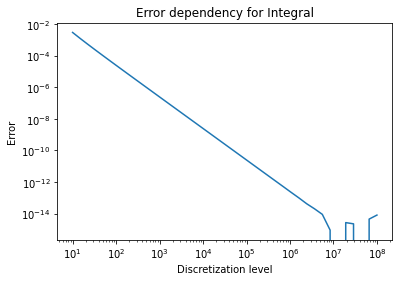

In [18]:
plt.plot(discrete_grid, errors)
plt.xlabel('Discretization level')
plt.ylabel('Error')
plt.title('Error dependency for Integral')

plt.yscale('log')
plt.xscale('log')